In [6]:
%load_ext autoreload
%autoreload 2
from neural import Neural
from utilities import evaluate_model_parallel, plot_TR_VAL, train_and_evaluate

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from numpy import mean, std
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed
from joblib_progress import joblib_progress

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Monk1 dataset loading

In [368]:
columns = ['y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'id']
df_train = pd.read_csv("MONK/monks-1.train",header=None, names=columns,sep=' ').set_index('id')

X_train = df_train.iloc[:, 1:7].to_numpy()
y_train = df_train.iloc[:, 0:1].to_numpy()

df_test = pd.read_csv("MONK/monks-1.test",header=None,names=columns,sep=' ').set_index('id')

X_test = df_test.iloc[:, 1:7].to_numpy()
y_test = df_test.iloc[:, 0:1].to_numpy()

encoder = OneHotEncoder(sparse=False)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

## Grid search

### Parameter Grid

In [151]:
param_grid = {
    'layer_structure': [
        [X_train.shape[1] ,6, 4, y_train.shape[1]]
    ],
    'epochs': [128],
    'batch_size': [8],
    'learning_rate': [0.05, 0.01, 0.005],
    'momentum': [0.93, 0.95, 0.97],
    'momentum_schedule': [False],
    'l2_lambda': [0, 0.001],
    'output_function': ['linear'],
    'hidden_function': ['tanh'],
    'init_method': ['he'],
    'optimizer':['nesterov'],
    'early_stopping': [True]
}
import itertools
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

permutations_dicts = [
    d for d in permutations_dicts 
    if not (
        (d['optimizer'] == 'adam' and d['momentum'] > 0) or
        (d['optimizer'] == 'nesterov' and d['momentum'] == 0 and not d['momentum_schedule']) or
        (d['optimizer'] == 'adam' and d['momentum_schedule']) or
        (d['optimizer'] == 'nesterov' and d['momentum_schedule'] and d['momentum'] > 0)
    )
]
len(permutations_dicts)

18

### Parallel grid search

In [152]:
with joblib_progress("Grid search", total=len(permutations_dicts)):
    res=Parallel(n_jobs=-1)(delayed(evaluate_model_parallel)(Neural, param, X_train, y_train,5,3) for param in permutations_dicts)

Output()

### Best hyperparameters

In [153]:
best_mse = float("inf")
best_res = []
for r in res:
    if mean(r[1])<best_mse:
        best_mse = mean(r[1])
        best_res = r
best_result = best_res[0]
best_res

[{'layer_structure': [17, 6, 4, 1],
  'epochs': 128,
  'batch_size': 8,
  'learning_rate': 0.05,
  'momentum': 0.95,
  'momentum_schedule': False,
  'l2_lambda': 0.001,
  'output_function': 'linear',
  'hidden_function': 'tanh',
  'init_method': 'he',
  'optimizer': 'nesterov',
  'early_stopping': True},
 [0.03813965684221328,
  0.016211468583694953,
  0.002216276696770594,
  0.0051266283328019946,
  0.03486829794593072,
  0.02547499099593669,
  0.001650943334180829,
  0.00525233081123226,
  0.0022392543263977218,
  0.0005249876822306295,
  0.028296555076800747,
  0.03278560847129843,
  0.013439522459205702,
  0.021095896207610057,
  0.047995145983941945]]

### BEST MODEL FOUND

In [159]:
nn = Neural(best_result['layer_structure'], 
            epochs = best_result['epochs'], 
            batch_size = best_result['batch_size'],
            learning_rate = best_result['learning_rate'],
            hidden_function = best_result['hidden_function'],
            output_function = best_result['output_function'],
            init_method = best_result['init_method'],
            momentum = best_result['momentum'],
            l2_lambda = best_result['l2_lambda'],
            early_stopping=True,
            verbose=0)
nn.fit(X_train,y_train)
print(f"train error: {mean_squared_error(nn.predict(X_train),y_train)}")
print(f"Test error: {mean_squared_error(nn.predict(X_test),y_test)}")

train error: 0.0003867434115711829
Test error: 0.0013751381402649374


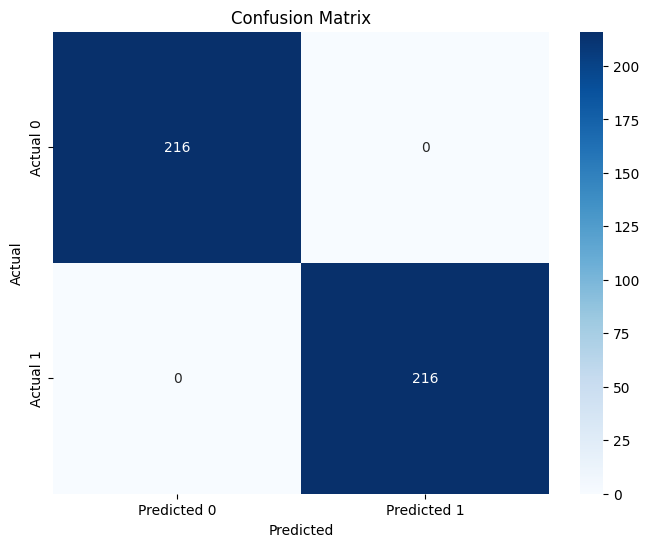

In [160]:
pred = nn.predict(X_test) > 0.5
pred.astype(int)

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

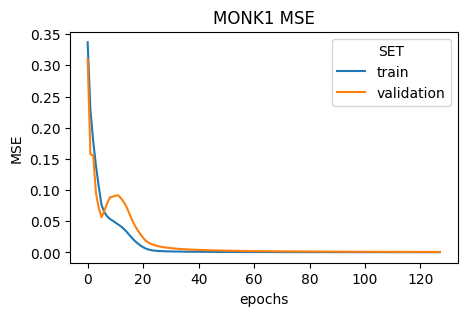

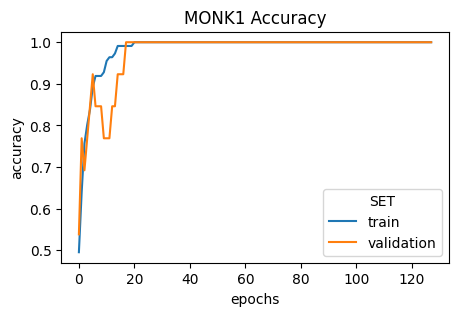

In [161]:
plot_TR_VAL(nn, title='MONK1 MSE', zoom_factor=0, curve='MSE', figsize=(5,3))
plot_TR_VAL(nn, title='MONK1 Accuracy', zoom_factor=0, curve='accuracy', figsize=(5,3))

# Monk2 dataset loading

In [163]:
columns = ['y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'id']
df = pd.read_csv("MONK/monks-2.train",header=None, names=columns,sep=' ').set_index('id')

X_train = df.iloc[:, 1:7].to_numpy()
y_train = df.iloc[:, 0:1].to_numpy()

df = pd.read_csv("MONK/monks-2.test",header=None,names=columns,sep=' ').set_index('id')

X_test = df.iloc[:, 1:7].to_numpy()
y_test = df.iloc[:, 0:1].to_numpy()

encoder = OneHotEncoder(sparse=False)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

## Grid Search

### Parameter grid

In [175]:
param_grid = {
    'layer_structure': [
        [X_train.shape[1] ,6, 4, y_train.shape[1]]
    ],
    'epochs': [128],
    'batch_size': [4,8],
    'learning_rate': [0.05, 0.01],
    'momentum': [0.90, 0.95],
    'momentum_schedule': [False, True],
    'l2_lambda': [0, 0.001],
    'output_function': ['linear'],
    'hidden_function': ['tanh'],
    'init_method': ['he'],
    'optimizer':['nesterov'],
    'early_stopping': [True]
}
import itertools
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
len(permutations_dicts)

32

### Paralle Grid Search

In [166]:
with joblib_progress("Grid search", total=len(permutations_dicts)):
    res=Parallel(n_jobs=-1)(delayed(evaluate_model_parallel)(Neural, param, X_train, y_train,5,3) for param in permutations_dicts)

Output()

### Best hyperparameters

In [167]:
best_mse = float("inf")
best_res = []
for r in res:
    if mean(r[1])<best_mse:
        best_mse = mean(r[1])
        best_res = r
best_result = best_res[0]
best_res

[{'layer_structure': [17, 6, 4, 1],
  'epochs': 128,
  'batch_size': 4,
  'learning_rate': 0.05,
  'momentum': 0.9,
  'momentum_schedule': False,
  'l2_lambda': 0,
  'output_function': 'linear',
  'hidden_function': 'tanh',
  'init_method': 'he',
  'optimizer': 'nesterov',
  'early_stopping': True},
 [0.0003393594860580872,
  0.0003240870318687797,
  0.00022480757955539742,
  0.00032135492068625536,
  0.0006120966264511115,
  0.0002665831323350617,
  0.0007432319724608639,
  0.0003102164413886194,
  0.00037851303249708697,
  6.931511544946464e-05,
  0.0003855962416015142,
  0.0008673743006003367,
  0.0004221641704236479,
  0.0005380320080401643,
  0.0037143513977286563]]

### BEST MODEL FOUND

In [177]:
nn = Neural(best_result['layer_structure'], 
            epochs = best_result['epochs'], 
            batch_size = best_result['batch_size'],
            learning_rate = best_result['learning_rate'],
            hidden_function = best_result['hidden_function'],
            output_function = best_result['output_function'],
            init_method = best_result['init_method'],
            momentum = best_result['momentum'],
            l2_lambda = best_result['l2_lambda'],
            early_stopping=True,
            verbose=0)
nn.fit(X_train,y_train)
print(f"train error: {mean_squared_error(nn.predict(X_train),y_train)}")
print(f"Test error: {mean_squared_error(nn.predict(X_test),y_test)}")

train error: 0.00012830993853527002
Test error: 0.00022756109070397237


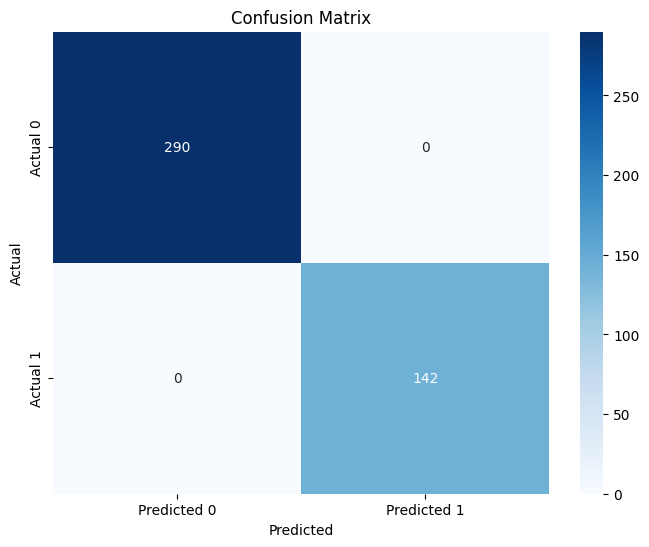

In [178]:
pred = nn.predict(X_test) > 0.5
pred.astype(int)

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

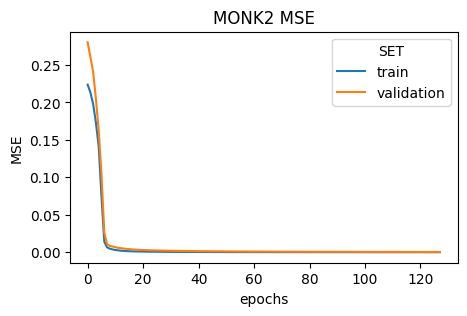

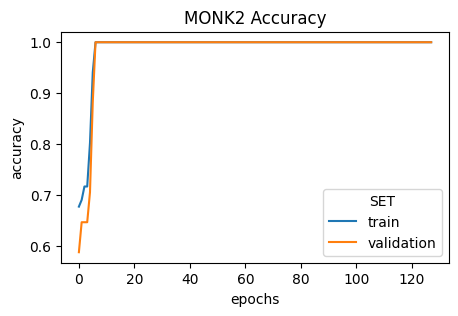

In [180]:
plot_TR_VAL(nn, title='MONK2 MSE', zoom_factor=0, curve='MSE', figsize=(5,3))
plot_TR_VAL(nn, title='MONK2 Accuracy', zoom_factor=0, curve='accuracy', figsize=(5,3))

# Monk3 dataset loading

In [7]:
columns = ['y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'id']
df_train = pd.read_csv("MONK/monks-3.train",header=None, names=columns,sep=' ').set_index('id')

X_train = df_train.iloc[:, 1:7].to_numpy()
y_train = df_train.iloc[:, 0:1].to_numpy()

df_test = pd.read_csv("MONK/monks-3.test",header=None,names=columns,sep=' ').set_index('id')

X_test = df_test.iloc[:, 1:7].to_numpy()
y_test = df_test.iloc[:, 0:1].to_numpy()

encoder = OneHotEncoder(sparse=False)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

D:\Python\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
D:\Python\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Grid Search

### Parameter grid

In [228]:
param_grid = {
    'layer_structure': [
        [X_train.shape[1] ,6, 4, y_train.shape[1]]
    ],
    'epochs': [256],
    'batch_size': [4],
    'learning_rate': [0.05, 0.01, 0.005],
    'momentum': [0.95],
    'momentum_schedule': [False],
    'l2_lambda': [0],
    'output_function': ['linear'],
    'hidden_function': ['tanh', 'sigmoid'],
    'init_method': ['he', 'xavier'],
    'optimizer':['nesterov'],
    'early_stopping': [True]
}
import itertools
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

permutations_dicts = [
    d for d in permutations_dicts 
    if not (
        (d['optimizer'] == 'nesterov' and d['momentum'] == 0 and not d['momentum_schedule']) or
        (d['optimizer'] == 'nesterov' and d['momentum_schedule'] and d['momentum'] > 0)
    )
]

len(permutations_dicts)

12

### Paralle grid search

In [229]:
from joblib import Parallel, delayed
from parallel_kfold import evaluate_model_parallel
from joblib_progress import joblib_progress

with joblib_progress("Grid search", total=len(permutations_dicts)):
    res=Parallel(n_jobs=-1)(delayed(evaluate_model_parallel)(Neural, param, X_train, y_train,5,3) for param in permutations_dicts)

Output()

### Best hyperparameters

In [230]:
best_mse = float("inf")
best_res = []
for r in res:
    if mean(r[1])<best_mse:
        best_mse = mean(r[1])
        best_res = r
best_result = best_res[0]
best_res

[{'layer_structure': [17, 6, 4, 1],
  'epochs': 256,
  'batch_size': 4,
  'learning_rate': 0.005,
  'momentum': 0.95,
  'momentum_schedule': False,
  'l2_lambda': 0,
  'output_function': 'linear',
  'hidden_function': 'sigmoid',
  'init_method': 'xavier',
  'optimizer': 'nesterov',
  'early_stopping': True},
 [0.1367509439045257,
  0.059037270868225446,
  0.062085330929066714,
  0.03728168191010752,
  0.07722321245372385,
  0.03739576413533568,
  0.05937247870927636,
  0.09427280187543235,
  0.108753681414878,
  0.04485934018075396,
  0.08470493343675672,
  0.19156518371873738,
  0.056203340779538695,
  0.026372946889633823,
  0.03215716509182285]]

### BEST MODEL FOUND

In [233]:
nn = Neural(best_result['layer_structure'], 
            epochs = best_result['epochs'], 
            batch_size = best_result['batch_size'],
            learning_rate = best_result['learning_rate'],
            hidden_function = best_result['hidden_function'],
            output_function = best_result['output_function'],
            init_method = best_result['init_method'],
            momentum = best_result['momentum'],
            l2_lambda = best_result['l2_lambda'],
            early_stopping=True,
            verbose=1)
nn.fit(X_train,y_train)
print(f"train error: {mean_squared_error(nn.predict(X_train),y_train)}")
print(f"Test error: {mean_squared_error(nn.predict(X_test),y_test)}")

Epoch: 0
Train MSE: 0.255	Val MSE: 0.249
Epoch: 1
Train MSE: 0.244	Val MSE: 0.247
Epoch: 2
Train MSE: 0.240	Val MSE: 0.240
Epoch: 3
Train MSE: 0.238	Val MSE: 0.240
Epoch: 4
Train MSE: 0.235	Val MSE: 0.238
Epoch: 5
Train MSE: 0.233	Val MSE: 0.236
Epoch: 6
Train MSE: 0.230	Val MSE: 0.234
Epoch: 7
Train MSE: 0.228	Val MSE: 0.232
Epoch: 8
Train MSE: 0.225	Val MSE: 0.230
Epoch: 9
Train MSE: 0.222	Val MSE: 0.227
Epoch: 10
Train MSE: 0.219	Val MSE: 0.225
Epoch: 11
Train MSE: 0.215	Val MSE: 0.222
Epoch: 12
Train MSE: 0.211	Val MSE: 0.218
Epoch: 13
Train MSE: 0.207	Val MSE: 0.214
Epoch: 14
Train MSE: 0.203	Val MSE: 0.210
Epoch: 15
Train MSE: 0.198	Val MSE: 0.206
Epoch: 16
Train MSE: 0.193	Val MSE: 0.201
Epoch: 17
Train MSE: 0.187	Val MSE: 0.195
Epoch: 18
Train MSE: 0.182	Val MSE: 0.190
Epoch: 19
Train MSE: 0.175	Val MSE: 0.183
Epoch: 20
Train MSE: 0.169	Val MSE: 0.177
Epoch: 21
Train MSE: 0.163	Val MSE: 0.170
Epoch: 22
Train MSE: 0.156	Val MSE: 0.162
Epoch: 23
Train MSE: 0.149	Val MSE: 0.155
Ep

Epoch: 108
Train MSE: 0.062	Val MSE: 0.024
Epoch: 109
Train MSE: 0.062	Val MSE: 0.024
Epoch: 110
Train MSE: 0.062	Val MSE: 0.024
Epoch: 111
Train MSE: 0.062	Val MSE: 0.024
Epoch: 112
Train MSE: 0.062	Val MSE: 0.024
Epoch: 113
Train MSE: 0.062	Val MSE: 0.024
Epoch: 114
Train MSE: 0.062	Val MSE: 0.024
Epoch: 115
Train MSE: 0.062	Val MSE: 0.024
Epoch: 116
Train MSE: 0.062	Val MSE: 0.024
Epoch: 117
Train MSE: 0.062	Val MSE: 0.024
Epoch: 118
Train MSE: 0.062	Val MSE: 0.024
Epoch: 119
Train MSE: 0.062	Val MSE: 0.024
Epoch: 120
Train MSE: 0.062	Val MSE: 0.024
Epoch: 121
Train MSE: 0.061	Val MSE: 0.024
Epoch: 122
Train MSE: 0.061	Val MSE: 0.024
Epoch: 123
Train MSE: 0.061	Val MSE: 0.024
Epoch: 124
Train MSE: 0.061	Val MSE: 0.023
Epoch: 125
Train MSE: 0.061	Val MSE: 0.023
Epoch: 126
Train MSE: 0.061	Val MSE: 0.023
Epoch: 127
Train MSE: 0.061	Val MSE: 0.023
Epoch: 128
Train MSE: 0.061	Val MSE: 0.023
Epoch: 129
Train MSE: 0.061	Val MSE: 0.023
Epoch: 130
Train MSE: 0.061	Val MSE: 0.023
Epoch: 131


Epoch: 209
Train MSE: 0.057	Val MSE: 0.021
Epoch: 210
Train MSE: 0.057	Val MSE: 0.021
Epoch: 211
Train MSE: 0.057	Val MSE: 0.021
Epoch: 212
Train MSE: 0.057	Val MSE: 0.021
Epoch: 213
Train MSE: 0.057	Val MSE: 0.021
Epoch: 214
Train MSE: 0.057	Val MSE: 0.021
Epoch: 215
Train MSE: 0.057	Val MSE: 0.021
Epoch: 216
Train MSE: 0.057	Val MSE: 0.021
Epoch: 217
Train MSE: 0.057	Val MSE: 0.021
Epoch: 218
Train MSE: 0.057	Val MSE: 0.021
Epoch: 219
Train MSE: 0.057	Val MSE: 0.021
Epoch: 220
Train MSE: 0.057	Val MSE: 0.021
Epoch: 221
Train MSE: 0.057	Val MSE: 0.021
Epoch: 222
Train MSE: 0.057	Val MSE: 0.021
Epoch: 223
Train MSE: 0.057	Val MSE: 0.021
Epoch: 224
Train MSE: 0.057	Val MSE: 0.021
Epoch: 225
Train MSE: 0.057	Val MSE: 0.021
Epoch: 226
Train MSE: 0.057	Val MSE: 0.021
Epoch: 227
Train MSE: 0.057	Val MSE: 0.021
Epoch: 228
Train MSE: 0.056	Val MSE: 0.021
Epoch: 229
Train MSE: 0.056	Val MSE: 0.021
Epoch: 230
Train MSE: 0.056	Val MSE: 0.020
Epoch: 231
Train MSE: 0.056	Val MSE: 0.020
Epoch: 232


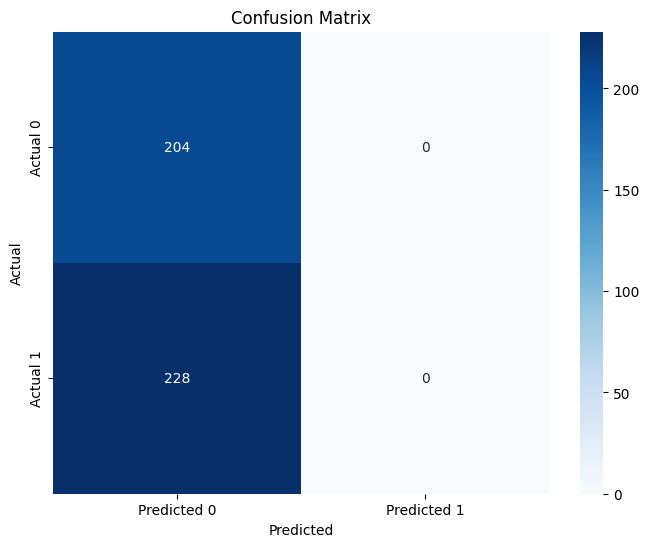


Accuracy: 0.47


In [366]:
pred = nn.predict(X_test) > 0.5
pred.astype(int)

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
print(f'\nAccuracy: {accuracy:.2f}')

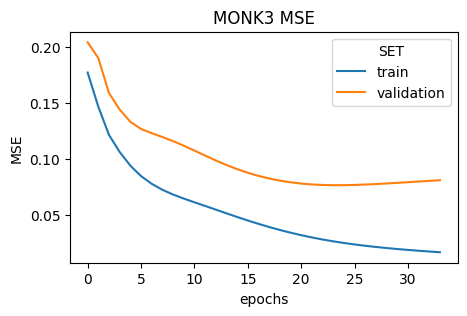

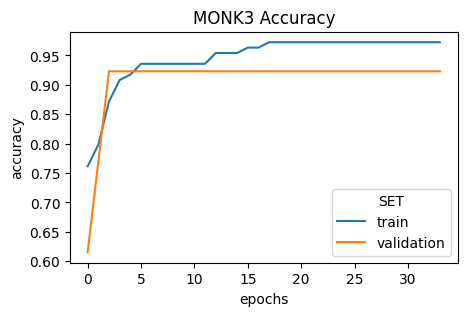

In [226]:
plot_TR_VAL(nn, title='MONK3 MSE', zoom_factor=0, curve='MSE', figsize=(5,3))
plot_TR_VAL(nn, title='MONK3 Accuracy', zoom_factor=0, curve='accuracy', figsize=(5,3))

## From the analysis conducted in "Preprocessing & Analysis.ipynb" we understood that the only 3 variables that determine the outcome of y are: x2, x4, x5

In [408]:
df_train = df_train.drop(columns=['x1', 'x3', 'x6'])
df_test = df_test.drop(columns=['x1', 'x3', 'x6'])

X_train = df_train.iloc[:, 1:].to_numpy()
y_train = df_train.iloc[:, 0:1].to_numpy()

X_test = df_test.iloc[:, 1:].to_numpy()
y_test = df_test.iloc[:, 0:1].to_numpy()

encoder = OneHotEncoder(sparse=False)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

## Run the model on reduced training set

In [534]:
nn = Neural( [X_train.shape[1], 6, 4, y_train.shape[1]], 
            epochs = 128,
            batch_size = 8,
            learning_rate = 0.05,
            hidden_function = 'sigmoid',
            output_function = 'linear',
            init_method = 'he',
            momentum = 0.95,
            momentum_schedule = False,
            l2_lambda = 0.0,
            early_stopping=True,
            patience=5,
            verbose=0)

nn.fit(X_train,y_train)
print(f"train error: {mean_squared_error(nn.predict(X_train),y_train)}")
print(f"Test error: {mean_squared_error(nn.predict(X_test),y_test)}")

print(f"train accuracy: {nn.accuracy['train'][-1]}")

train error: 0.058271139729189826
Test error: 0.041852175176347574
train accuracy: 0.926605504587156


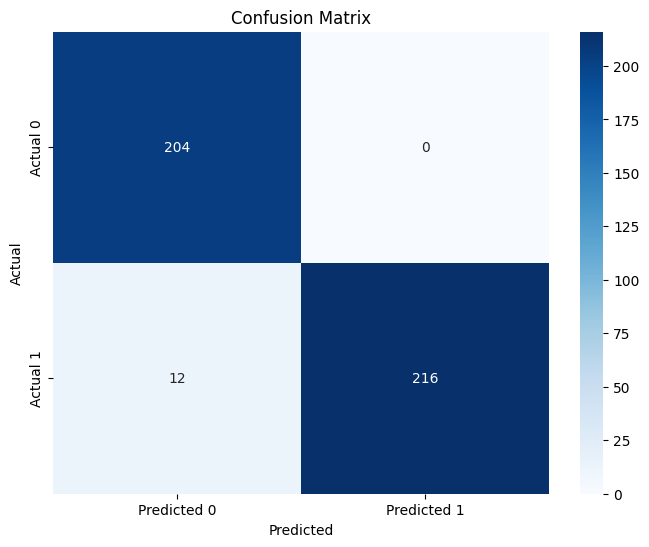


Accuracy on Test: 0.97


In [535]:
pred = nn.predict(X_test) > 0.5
pred.astype(int)

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
print(f'\nAccuracy on Test: {accuracy:.2f}')

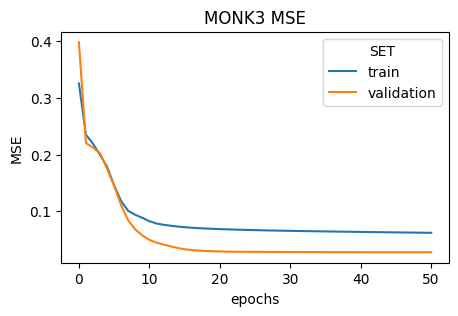

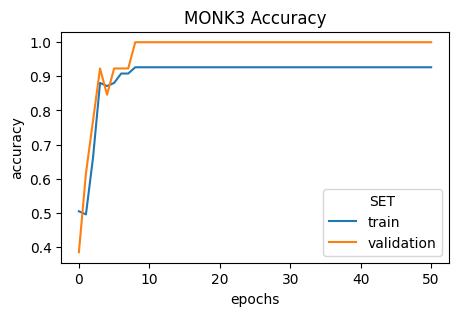

In [536]:
plot_TR_VAL(nn, title='MONK3 MSE', zoom_factor=0, curve='MSE', figsize=(5,3))
plot_TR_VAL(nn, title='MONK3 Accuracy', zoom_factor=0, curve='accuracy', figsize=(5,3))

### To have a more reliable estimate of the model, we perform several training

In [162]:
# MONK 1
train_and_evaluate(nn, X_train, y_train, X_test, y_test, n_iterations=10)

Mean Train Loss      Mean Test Loss       Std Train Loss       Std Test Loss       
--------------------------------------------------------------------------------
0.0003               0.0023               0.0001               0.0031              


Mean Train Accuracy  Mean Test Accuracy   Std Train Accuracy   Std Test Accuracy   
--------------------------------------------------------------------------------
1.0000               0.9986               0.0000               0.0042              


In [173]:
# MONK 2
train_and_evaluate(nn, X_train, y_train, X_test, y_test, n_iterations=10)

Mean Train Loss      Mean Test Loss       Std Train Loss       Std Test Loss       
--------------------------------------------------------------------------------
0.0001               0.0002               0.0001               0.0001              


Mean Train Accuracy  Mean Test Accuracy   Std Train Accuracy   Std Test Accuracy   
--------------------------------------------------------------------------------
1.0000               1.0000               0.0000               0.0000              


In [528]:
# MONK 3
train_and_evaluate(nn, X_train, y_train, X_test, y_test, n_iterations=10)

Mean Train Loss      Mean Test Loss       Std Train Loss       Std Test Loss       
--------------------------------------------------------------------------------
0.0499               0.0237               0.0055               0.0054              


Mean Train Accuracy  Mean Test Accuracy   Std Train Accuracy   Std Test Accuracy   
--------------------------------------------------------------------------------
0.9393               0.9806               0.0075               0.0127              


## MODEL FOUND FOR EACH MONK TASK

### MONK 1

 {'layer_structure': [17, 6, 4, 1],
  'epochs': 128,
  'batch_size': 8,
  'learning_rate': 0.05,
  'momentum': 0.95,
  'momentum_schedule': False,
  'l2_lambda': 0.001,
  'output_function': 'linear',
  'hidden_function': 'tanh',
  'init_method': 'he',
  'optimizer': 'nesterov',
  'early_stopping': True}

### MONK 2

{'layer_structure': [17, 6, 4, 1],
  'epochs': 128,
  'batch_size': 4,
  'learning_rate': 0.05,
  'momentum': 0.9,
  'momentum_schedule': False,
  'l2_lambda': 0,
  'output_function': 'linear',
  'hidden_function': 'tanh',
  'init_method': 'he',
  'optimizer': 'nesterov',
  'early_stopping': True}

### MONK 3

{'layer_structure': [17, 6, 4, 1],
  'epochs': 128,
  'batch_size': 8,
  'learning_rate': 0.05,
  'momentum': 0.95,
  'momentum_schedule': False,
  'l2_lambda': 0,
  'output_function': 'linear',
  'hidden_function': 'sigmoid',
  'init_method': 'he',
  'optimizer': 'nesterov',
  'early_stopping': True}